In [197]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

focal_length = 970.0
baseline = 50.0
data_path = "HW1-1-data"
data_path_save = "HW1-1-output"

pairs = ["1262", "1755", "1131", "0000"]

num_disparities = 64
block_size = 5


Colorbar Function

In [198]:
def add_colorbar(image, cmap_height=256, bar_width=20):
    """Add a vertical colorbar to the right of the image"""
    colorbar = np.zeros((cmap_height, bar_width, 3), dtype=np.uint8)
    for i in range(cmap_height):
        colorbar[i, :] = cv2.applyColorMap(
            np.array([[i]], dtype=np.uint8), cv2.COLORMAP_JET
        )[0, 0]
    # Resize colorbar to match image height
    colorbar = cv2.resize(colorbar, (bar_width, image.shape[0]))
    return np.hstack((image, colorbar))


cv2.imshow function for inline viewing in notebook

In [199]:
def cv2_imshow_nb(img, title=""):
    plt.figure(figsize=(6,6))
    if len(img.shape) == 2:  
        plt.imshow(img, cmap="gray")
    else:  
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


Processing


Processing pair: 1262
--- Metrics for 1262 ---
Valid pixel ratio: 86.04%
Texture variance: 257.65
-------------------------------------


C:\Users\balsa\AppData\Local\Temp\ipykernel_8604\4274397535.py:53: RuntimeWarning: invalid value encountered in cast
  depth_vis = ((depth_vis - 200) / (4000 - 200) * 255).astype(np.uint8)


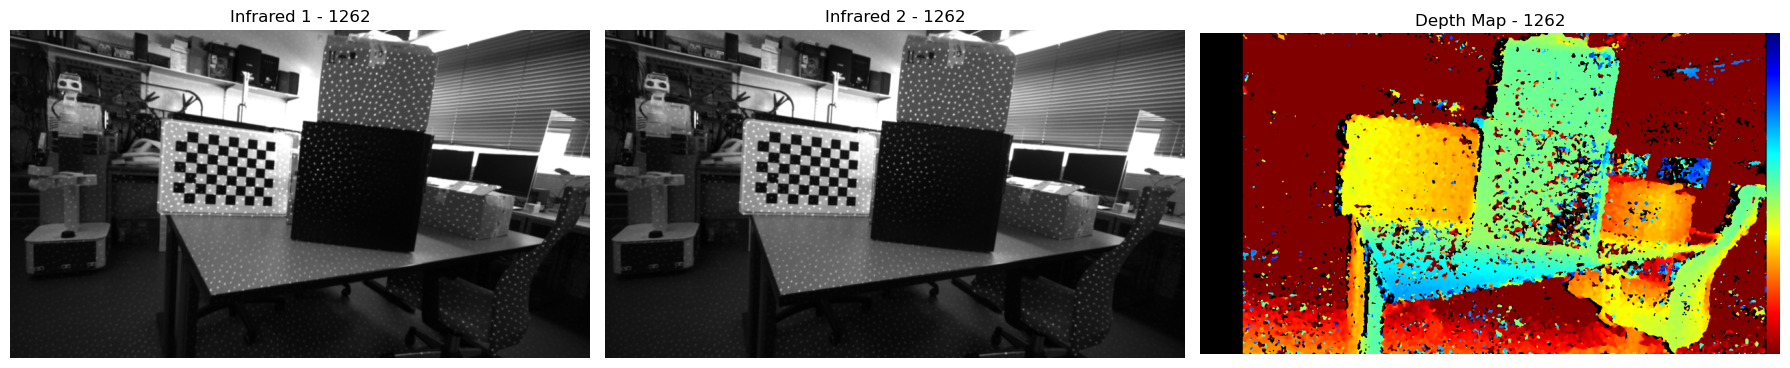


Processing pair: 1755
--- Metrics for 1755 ---
Valid pixel ratio: 85.85%
Texture variance: 227.52
-------------------------------------


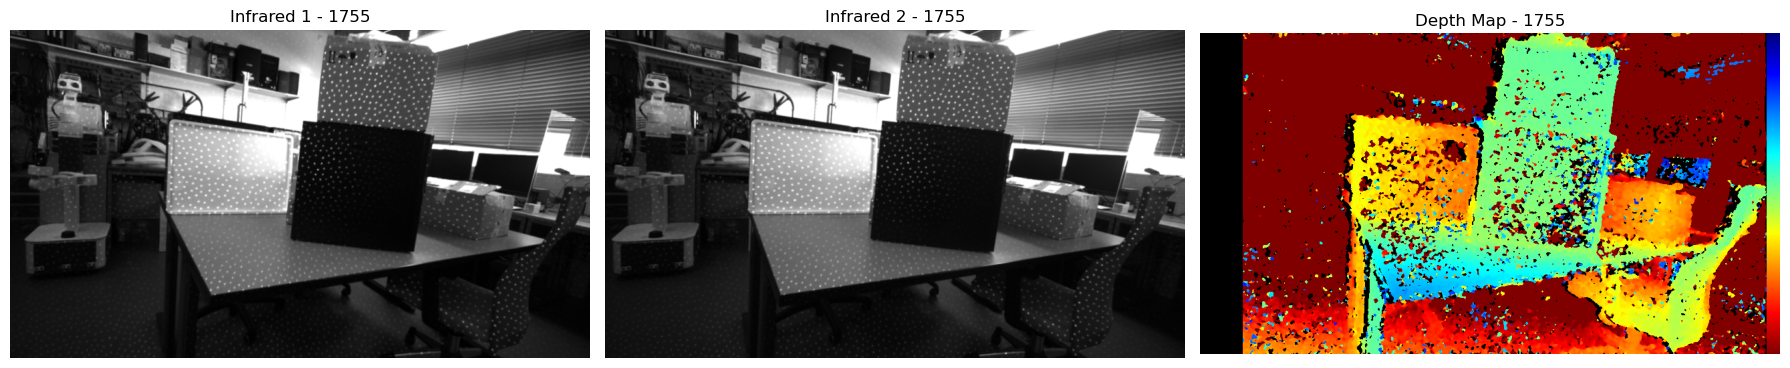


Processing pair: 1131
--- Metrics for 1131 ---
Valid pixel ratio: 80.57%
Texture variance: 187.24
-------------------------------------


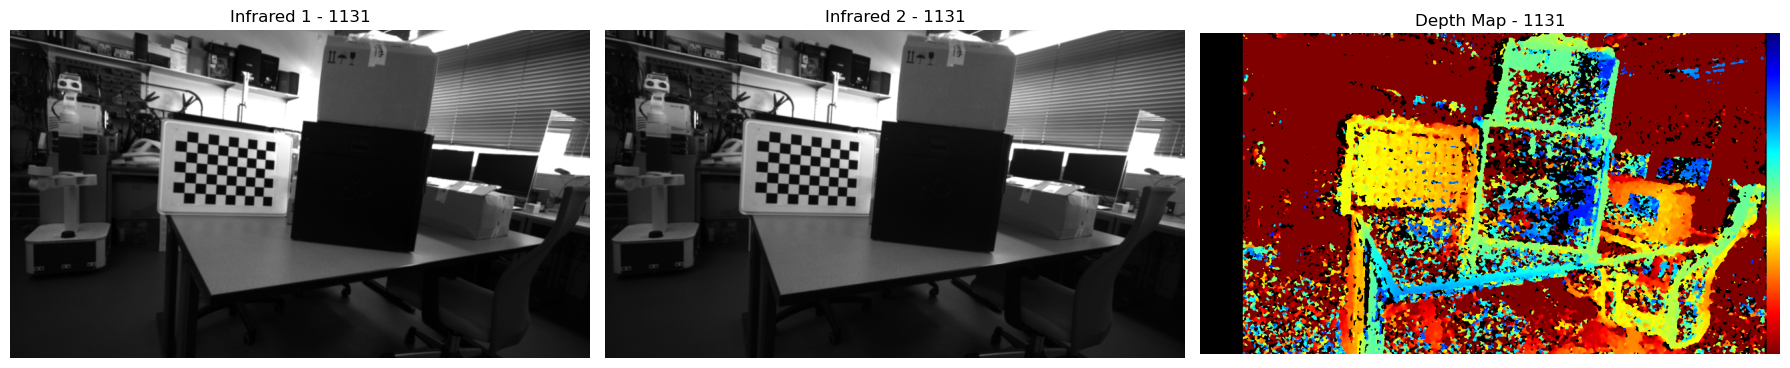


Processing pair: 0000
--- Metrics for 0000 ---
Valid pixel ratio: 79.53%
Texture variance: 159.67
-------------------------------------


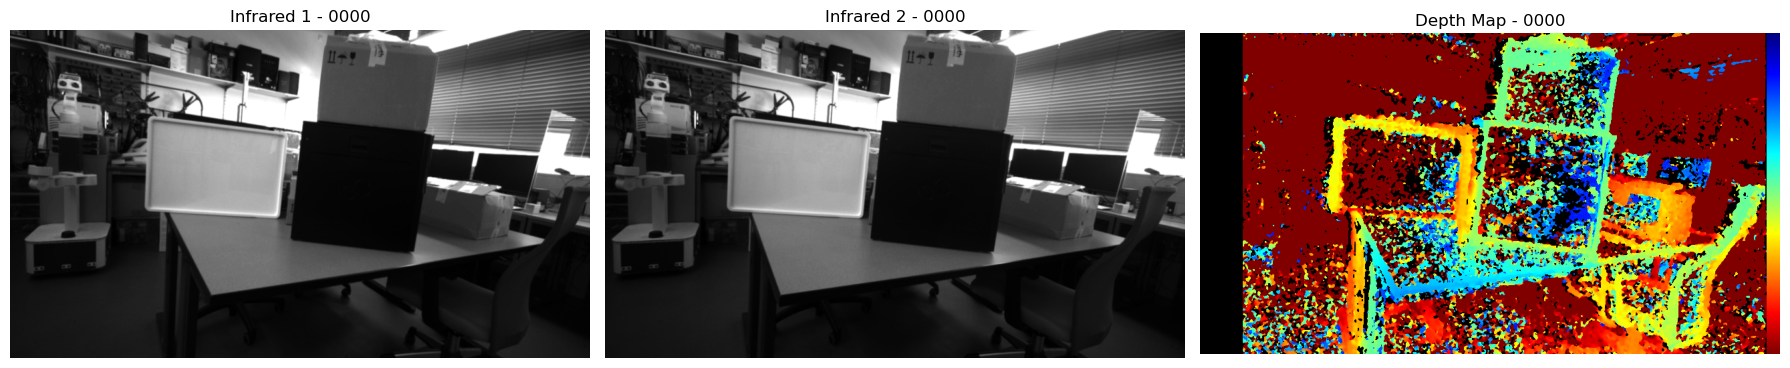


SUMMARY:
image | Valid pixel ratio | Texture variance
--------------------------------------------------
1262  |            86.04% | 257.65
1755  |            85.85% | 227.52
1131  |            80.57% | 187.24
0000  |            79.53% | 159.67


In [200]:
metrics_list = []

for pair_id in pairs:
    print(f"\nProcessing pair: {pair_id}")

    # Load images
    ir1 = cv2.imread(
        os.path.join(data_path, f"infra1_{pair_id}.jpg"), cv2.IMREAD_GRAYSCALE
    )
    ir2 = cv2.imread(
        os.path.join(data_path, f"infra2_{pair_id}.jpg"), cv2.IMREAD_GRAYSCALE
    )
    color = cv2.imread(os.path.join(data_path, f"color{pair_id}.jpg"))

    if ir1 is None or ir2 is None or color is None:
        print(f"Could not load images for pair {pair_id}")
        continue

    # Compute disparity map
    stereo = cv2.StereoSGBM_create(numDisparities=num_disparities, blockSize=block_size)
    disparity = stereo.compute(ir1, ir2).astype(np.float32) / 16.0
    disparity[disparity <= 0] = np.nan

    # Depth quality assessment
    disp = disparity.copy()
    valid_mask = np.isfinite(disp)
    total = disp.size
    valid = np.count_nonzero(valid_mask)
    valid_ratio = valid / total

    # Texture measure of IR1
    lap = cv2.Laplacian(ir1, cv2.CV_64F)
    texture_var = float(np.var(lap))

    # Store cleanly
    metrics_list.append({
        "pair": pair_id,
        "valid_ratio": valid_ratio,
        "texture_var": texture_var
    })

    # Print 
    print(f"--- Metrics for {pair_id} ---")
    print(f"Valid pixel ratio: {valid_ratio*100:.2f}%")
    print(f"Texture variance: {texture_var:.2f}")
    print("-------------------------------------")

    # Compute depth
    depth = (focal_length * baseline) / disparity

    # Normalize depth and apply color map
    depth_vis = np.clip(depth, 200, 4000)
    depth_vis = ((depth_vis - 200) / (4000 - 200) * 255).astype(np.uint8)

    # Create a mask for fail values
    fail_mask = np.isnan(depth)

    # Apply colormap
    depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

    # Overwrite fail values with black
    depth_color[fail_mask] = (0, 0, 0)

    # Add colorbar
    depth_color_bar = add_colorbar(depth_color)

    # Display images inline using cv2.imshow
    # Display IR1, IR2, Depth in a single row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # IR1
    axes[0].imshow(ir1, cmap="gray")
    axes[0].set_title(f"Infrared 1 - {pair_id}")
    axes[0].axis("off")

    # IR2
    axes[1].imshow(ir2, cmap="gray")
    axes[1].set_title(f"Infrared 2 - {pair_id}")
    axes[1].axis("off")

    # DEPTH
    axes[2].imshow(cv2.cvtColor(depth_color_bar, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f"Depth Map - {pair_id}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # Save output
    os.makedirs(data_path_save, exist_ok=True)
    cv2.imwrite(os.path.join(data_path_save, f"depth_{pair_id}.jpg"), depth_color_bar)

print("\nSUMMARY:")
print("image | Valid pixel ratio | Texture variance")
print("-"*50)

for m in metrics_list:
    print(
        f"{m['pair']:>4}  | "
        f"          {m['valid_ratio']*100:6.2f}% | "
        f"{m['texture_var']:.2f}"
    )

A. The checkerboard provides high contrast features (edges, corners, patterns) making it easier to find correspondences between the stereo images, leading to a more accurate disparity and depth estimation.

In contrast, a plane without texture looks almost identical across neighbooring pixels. As a result, the stereo matching cannot find correspondences as accurately, leading to poor disparity and depth estimation (e.g., difference between checkerboard and PC case in Depth Map-1131; difference between the checkerboard in Depth Map-1131 and the white surface that replaces it in Depth Map-0000). 

B. Laser pattern adds artificial detail and contrast, which help textureless regions to match better. 

Images without laser pattern depend entirely on natural textures (see higher texture variance values for images 1262 and 1755 in the SUMMARY table), which may be insufficient in some areas, leading to lower quality disparity and depth maps.

This behaviour can be inferred from the lower number of failed disparity values (displayed in black) and more consistent and smoother estimations of Depth Map-1262 and Depth Map-1755, compared to lower quality results shown in Depth Map-1131 and Depth Map-0000. It is also supported by the percentage of pixels with valid disparity values showcased in the SUMMARY table. The result of the laser pattern is therefore higher quality disparity and depth maps.